### Inference

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
import os
import sys
import inspect

# insert root dir into sys
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
root_dir = os.path.dirname(currentdir)
# print(root_dir)

if root_dir not in sys.path:
     sys.path.insert(0, root_dir)

### Weight and measurement example

##### sim0 implemented native rejection:

Features: Slow
<br>
Refs:
<br>http://dippl.org/

In [3]:
from sim0 import Dist, Dist1, ARDist, MH
from sim0 import Normal, Uniform
from sim0 import RejectionSampler
from sim0 import plot_hist

In [6]:
a = Uniform("a", a=0.0, b=10.0)
b = Uniform("b", a=0.0, b=3.0)
w_guess = Normal("w_guess", mu=a, sigma=b)

# conditioned distributions:
w_target = Normal("w_target", mu=8.5, sigma=1)
measurement = Normal("m", mu=w_target, sigma=0.75)

model = [a, b, w_guess, w_target, measurement]
condition = ["abs($w_guess - $w_target) <= 0.3",
             "abs($m-9.5) <= 0.4"]

Infer = RejectionSampler(model, condition) 

In [8]:
result = Infer.run_n(620)

i =  0
t=  3
t=  2
t=  1
t=  22
t=  6
t=  376
t=  2
t=  4
i =  10
t=  422
i =  20
t=  2578
i =  30
i =  40
i =  50
i =  60
i =  70
i =  80
i =  90
i =  100
i =  110
i =  120
i =  130
i =  140
i =  150
i =  160
i =  170
i =  180
i =  190
i =  200
i =  210
i =  220
i =  230
i =  240
t=  3557
i =  250
i =  260
i =  270
i =  280
i =  290
t=  5
t=  6
i =  300
t=  3676
i =  310
i =  320
i =  330
i =  340
t=  4368
i =  350
t=  5188
i =  360
i =  370
i =  380
i =  390
i =  400
i =  410
i =  420
i =  430
i =  440
i =  450
i =  460
i =  470
i =  480
i =  490
i =  500
t=  5270
i =  510
i =  520
i =  530
i =  540
i =  550
i =  560
i =  570
i =  580
i =  590
i =  600
i =  610


Results:

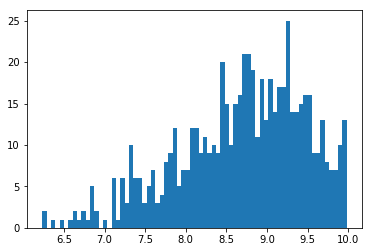

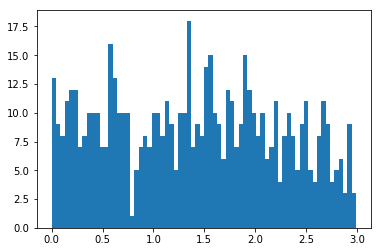

In [11]:
# for a accurate is 9.14:
xs = result['a']

# for b accurate is 0.6:
xs1 = result['b']
plot_hist(xs)
plot_hist(xs1)


##### pyro the evidence lower bound variational inference:
Features: fast
<br>
Refs:<br>
<br>https://arxiv.org/abs/1301.1299
<br>http://pyro.ai/examples/svi_part_i.html
<br>https://github.com/pyro-ppl/pyro/blob/dev/pyro/contrib/minipyro.py
<br>see also `pyro_basis.ipynb`

In [14]:
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
import numpy as np

In [15]:
# condition0
def conditioned_scale_obs(guess):  # equivalent to conditioned_scale above
    # print("conditioned guess:", guess)
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we condition on measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 0.75), obs=9.5)

# guide0
def scale_parametrized_guide(guess):
    
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    # print("guide a:", a)
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

In [16]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale_obs,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 250  # 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

Results:

In [17]:
# accurate 9.14
print(len(a))
print(a[-1])
# accurate 0.6
print(len(b))
print(b[-1])


250
8.879049301147461
250
0.7590230107307434


##### pymc implementation
not working

In [13]:
import pymc
from pymc import MCMC
from pymc import Normal, DiscreteUniform, Exponential, deterministic, Poisson, Uniform


In [17]:
weight = Normal('w', 8.5, 1)
measurment = Normal('m', weight, 0.75, value=np.array([9.5]),
                    observed=True)
a = Uniform('a', 8, 10)
b = Uniform('b',0,1)
weight_measure = Normal('wm', a, b)

@deterministic(plot=False)
def rate(w1=weight, w2=weight_measure):
    return int(w1==w2)

rate1 = pymc.Bernoulli('r1', rate, value=rate.value, observed=True)

In [18]:
M = MCMC([weight, measurment, a,b, weight_measure, rate,rate1])
M.sample(iter=10000, burn=1000, thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 4.6 sec

In [22]:
%matplotlib
plt.plot(M.trace("a")[:])

Using matplotlib backend: Qt5Agg


##### Non-parametric pdf estimation
with scipy.stats.gaussian_kde

In [5]:
def measure(n):
    #      "Measurement model, return two coupled measurements."
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1+m2, m1-m2

In [6]:
m1, m2 = measure(2000)
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()


In [15]:
m1, m2

(array([-1.44464964, -0.9259564 , -0.71430056, ..., -2.00727006,
        -0.30162927, -0.59003687]),
 array([ 0.28466947, -1.50845182, -0.25901784, ...,  0.32613885,
        -2.03287355,  0.17495946]))

In [8]:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

In [25]:
%matplotlib
fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()


Using matplotlib backend: Qt5Agg


In [22]:
X

array([[-3.40090975, -3.40090975, -3.40090975, ..., -3.40090975,
        -3.40090975, -3.40090975],
       [-3.32445723, -3.32445723, -3.32445723, ..., -3.32445723,
        -3.32445723, -3.32445723],
       [-3.24800472, -3.24800472, -3.24800472, ..., -3.24800472,
        -3.24800472, -3.24800472],
       ...,
       [ 4.01498442,  4.01498442,  4.01498442, ...,  4.01498442,
         4.01498442,  4.01498442],
       [ 4.09143694,  4.09143694,  4.09143694, ...,  4.09143694,
         4.09143694,  4.09143694],
       [ 4.16788946,  4.16788946,  4.16788946, ...,  4.16788946,
         4.16788946,  4.16788946]])